In [312]:
'''
Signals Project, Deliverable #2
 
BME 252 - Linear Systems and Signals
 
Sunny Willert 20619549
Vincent Shadbolt 20617236
Samantha Feng 20604727
 
June 22, 2017
 
'''

'\nSignals Project, Deliverable #2\n \nBME 252 - Linear Systems and Signals\n \nSunny Willert 20619549\nVincent Shadbolt 20617236\nSamantha Feng 20604727\n \nJune 22, 2017\n \n'

In [313]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate as itg
from scipy import signal
from matplotlib import pyplot as plt

import allantools
from allantools import noise

In [314]:
# import data, remove unnecessary cells
#data = pd.read_csv('C:\Users\Sunny\Documents\signals_project\sunny_1.csv', header=0)
# data = pd.read_csv('C:\\Users\\Sam\\Documents\\Signals\\sunny_1.csv', header=0)
data = pd.read_csv('/Users/vincentshadbolt/Dropbox/University of Waterloo/2B/BME 252 - Linear Signals and Systems/Project/sunny_1.csv', header=0)
del data['Unnamed: 7']

# instantiate new unit vector df, pitch/roll df, and global variable df
unit_vec = pd.DataFrame(columns=['time','mag_a', 'ax_u','ay_u','az_u'])
pitch_roll = pd.DataFrame(columns=['time', 'pitch','roll','pitch_corr','roll_corr'])
global_vals = pd.DataFrame(columns=['time','gx','gy','gz','gx_1','gy_1','gz_1','gx_2','gy_2','gz_2'])
global_vals['time'] = data['time']

# create integral dataframes
int_1 = pd.DataFrame(columns=['time','wx_1','wy_1','wz_1'])

In [315]:
# integrate angular velocity signal for angle
for _dir in ['x','y','z']:
    for idx,row in data.iterrows():
        if idx == 0 or idx == 1:
            data.loc[idx,'w{}_1'.format(_dir)] = 0
        else:
            a_below_idx = itg.cumtrapz(data['w{}'.format(_dir)][:idx+1], data['time'][:idx+1])
            a_inst = a_below_idx[-1] - a_below_idx[-2]
            int_1.loc[idx,'w{}_1'.format(_dir)] = a_inst
            int_1['time'] = data['time']
            
int_1 = int_1.drop(int_1[int_1.wx_1 == 0].index)
int_1 = int_1.reset_index()

In [316]:
# calculate magnitude of acceleration to determine unit vector for acceleration in each direction
unit_vec['time'] = data['time']
unit_vec['mag_a'] = np.sqrt(data['ax']**2 + data['ay']**2 + data['az']**2)

# determine unit vectors for acceleration for pitch and roll calculations
for _dir in ['x', 'y', 'z']:
    unit_vec['a{}_u'.format(_dir)] = data['a{}'.format(_dir)] / unit_vec['mag_a']

# calculating pitch and roll only for time in which subject is standing
pitch_roll['time'] = data['time']
pitch_roll = pitch_roll.drop(pitch_roll[pitch_roll.time < 7].index)

for _type in ['pitch', 'roll']:
    if _type == 'pitch':
        pitch_roll[_type] = -np.arctan2(unit_vec['az_u'], np.sqrt(unit_vec['ax_u']**2 + unit_vec['ay_u']**2))*(180/np.pi)
    elif _type == 'roll':
        pitch_roll[_type] = -np.arctan2(-unit_vec['ax_u'], unit_vec['ay_u'])*(180/np.pi)

for _type in ['pitch_corr','roll_corr']:
    if _type == 'pitch_corr':
        pitch_roll[_type] = 0.98*int_1['wx_1']+0.02*pitch_roll['pitch']
    elif _type == 'roll_corr':
        pitch_roll[_type] = 0.98*int_1['wz_1']+0.02*pitch_roll['roll']
        
# determining average pitch and roll when still
pitch_avg = np.mean(pitch_roll['pitch_corr'])
roll_avg = np.mean(pitch_roll['roll_corr'])
print (pitch_avg)
print (roll_avg)

0.119021548016
0.403916109817


In [317]:
# Calculate Rotation Matrix
pitch_avg_rad = pitch_avg*np.pi/180
roll_avg_rad = roll_avg*np.pi/180

# X rotation is based on pitch
rotation_x = np.matrix([[1, 0, 0], [0, np.cos(pitch_avg_rad), np.sin(pitch_avg_rad)], [0, -np.sin(pitch_avg_rad), np.cos(pitch_avg_rad)]])
# Y rotation based off Yaw - yaw = 0 therefore all anges = 0
rotation_y = np.matrix([[np.cos(0), 0, -np.sin(0)], [0, 1, 0], [np.sin(0), 0, np.cos(0)]])
# Z rotation is based on roll
rotation_z = np.matrix([[np.cos(roll_avg_rad), np.sin(roll_avg_rad), 0], [-np.sin(roll_avg_rad), np.cos(roll_avg_rad), 0], [0, 0, 1]])
rotation_total = rotation_x*rotation_y*rotation_z

In [318]:
# getting in global coordinates
for _dir in range(len(rotation_total)):
    if _dir == 0: var = 'gx'
    elif _dir == 1: var = 'gy'
    elif _dir == 2: var = 'gz'
        
    global_vals[var] = data['ax']*rotation_total[_dir].item(0) + data['ay']*rotation_total[_dir].item(1) + data['az']*rotation_total[_dir].item(2) 

In [319]:
# find landings by finding local minimal in signal for angular acceleration in the z-axis
global_vals['wx'] = data['wx']
global_vals['wy'] = data['wy']
global_vals['wz'] = data['wz']
indices = signal.find_peaks_cwt(-global_vals['wx'], np.arange(1,650))
indices[:] = [x - 1 for x in indices]
landings = global_vals.loc[indices]
landings = landings[landings['wx'] < -2]
landings

,time,gx,gy,gz,gx_1,gy_1,gz_1,gx_2,gy_2,gz_2,wx,wy,wz
2230,12.325,3.084651,10.609363,14.837993,NaN,NaN,NaN,NaN,NaN,NaN,-4.1492,-0.7819,-1.7449
3086,17.043,0.931359,5.824805,-18.672140,NaN,NaN,NaN,NaN,NaN,NaN,-4.2035,-3.1542,-5.3327
4176,23.046,-14.869870,5.742194,-1.341931,NaN,NaN,NaN,NaN,NaN,NaN,-3.5835,-2.4192,-0.3675
5084,28.053,-27.534280,23.600321,-2.129030,NaN,NaN,NaN,NaN,NaN,NaN,-3.9319,0.0746,-3.4493
5982,32.998,-11.594606,23.470259,-15.458789,NaN,NaN,NaN,NaN,NaN,NaN,-5.1218,0.7563,-3.7710
6917,38.144,-2.770459,14.144953,7.240632,NaN,NaN,NaN,NaN,NaN,NaN,-4.4581,0.3494,-2.3596
7691,42.404,7.354286,-5.120669,-13.809393,NaN,NaN,NaN,NaN,NaN,NaN,-2.9518,-0.4559,-5.3167
8627,47.574,-13.301239,25.402642,-0.872771,NaN,NaN,NaN,NaN,NaN,NaN,-3.6059,0.0778,-5.5926
9782,53.924,-10.233181,20.858687,-1.933334,NaN,NaN,NaN,NaN,NaN,NaN,-4.2696,0.1577,-2.4427


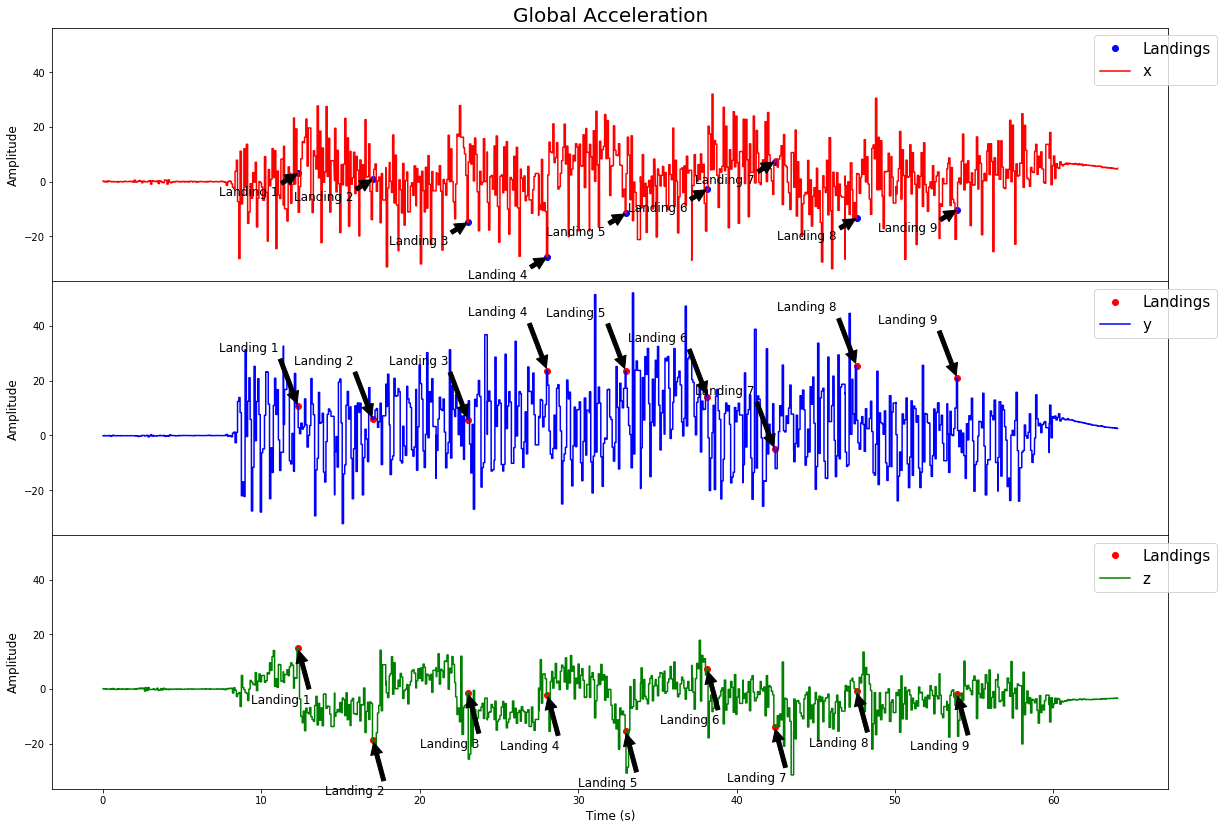

In [320]:
### GLOBAL ACCELERATION PLOT ###

# create 4 subfigures for acceleration: overall acceleration, as well as acceleration in the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))

# annotating landings for each acceleration graph
ax1.plot(landings['time'], landings['gx'], 'bo', label='Landings')
ax2.plot(landings['time'], landings['gy'], 'ro', label='Landings')
ax3.plot(landings['time'], landings['gz'], 'ro', label='Landings')

count = 1
for idx, row in landings.iterrows():
    ax1.annotate('Landing {}'.format(count), (row['time'], row['gx']), xytext=(row['time']-5, row['gx']-8), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
    ax2.annotate('Landing {}'.format(count), (row['time'], row['gy']), xytext=(row['time']-5, row['gy']+20), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
    ax3.annotate('Landing {}'.format(count), (row['time'], row['gz']), xytext=(row['time']-3, row['gz']-20), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
    count += 1

ax1.plot(global_vals['time'], global_vals['gx'], 'r-', label='x')
ax2.plot(global_vals['time'], global_vals['gy'], 'b-', label='y')
ax3.plot(global_vals['time'], global_vals['gz'], 'g-', label='z')

# Format labels and title for graphs
ax1.set_title('Global Acceleration', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

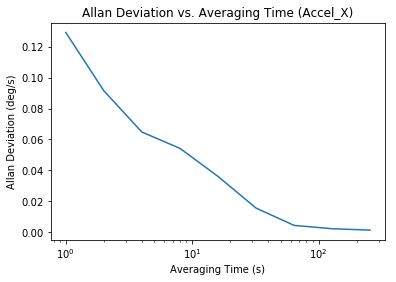

In [388]:
# Allan Variance
allan_x = allantools.Dataset(global_vals['gx'][0:906])
avariance_x = allan_x.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_x['taus'], avariance_x['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Accel_X)')
plt.xscale('log')
#plt.yscale('log')
# plt.annotate('BS', xy=(1, 0.13415635), xytext=(1, 0.01),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
plt.show()

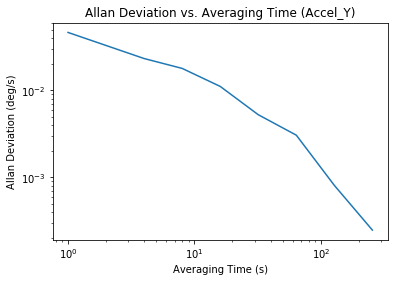

In [352]:
allan_y = allantools.Dataset(global_vals['gy'][0:906])
avariance_y = allan_y.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_y['taus'], avariance_y['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Accel_Y)')
plt.xscale('log')
plt.yscale('log')
# plt.annotate('BS', xy=(1, 0.0478635), xytext=(1, 0.01),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
plt.show()

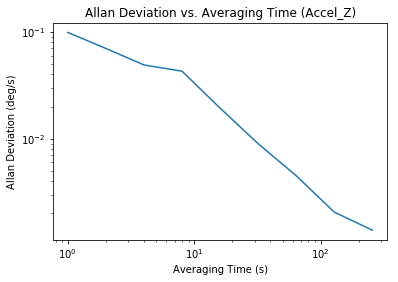

In [361]:
allan_z = allantools.Dataset(global_vals['gz'][0:906])
avariance_z = allan_z.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_z['taus'], avariance_z['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Accel_Z)')
plt.xscale('log')
plt.yscale('log')
# plt.annotate('BS', xy=(1, 0.09740188), xytext=(1, 0.01),
#             arrowprops=dict(facecolor='black', shrink=0),
#             )
plt.show()

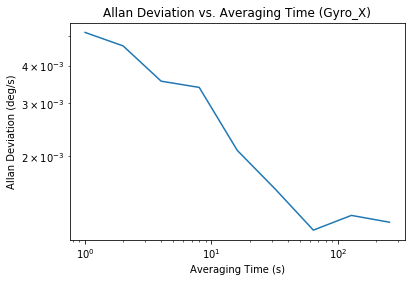

In [363]:
allan_wx = allantools.Dataset(data['wx'][0:906])
avariance_wx = allan_wx.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_wx['taus'], avariance_wx['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Gyro_X)')
plt.xscale('log')
plt.yscale('log')
# plt.annotate('BS', xy=(1, 0.00515635), xytext=(1, 0.0001),
#             arrowprops=dict(facecolor='black', shrink=0),
#             )
plt.show()

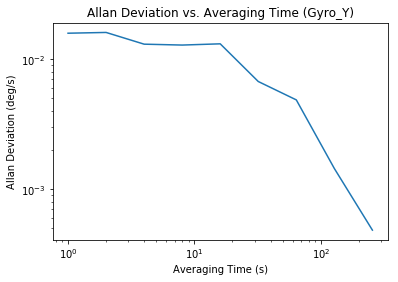

In [364]:
allan_wy = allantools.Dataset(data['wy'][0:906])
avariance_wy = allan_wy.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_wy['taus'], avariance_wy['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Gyro_Y)')
plt.xscale('log')
plt.yscale('log')
# plt.annotate('BS', xy=(31, 0.00659635), xytext=(1, 0.0001),
#             arrowprops=dict(facecolor='black', shrink=0),
#             )
plt.show()

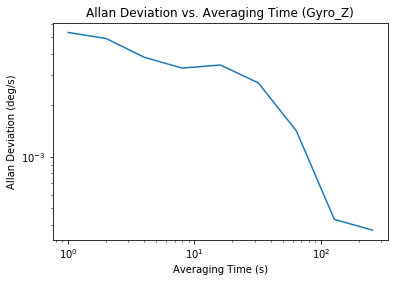

In [365]:
allan_wz = allantools.Dataset(data['wz'][0:906])
avariance_wz = allan_wz.compute("adev")
# print(avariance_wx['taus'])
# print(avariance_wx['stat'])
plt.plot(avariance_wz['taus'], avariance_wz['stat'])
plt.ylabel('Allan Deviation (deg/s)')
plt.xlabel('Averaging Time (s)')
plt.title('Allan Deviation vs. Averaging Time (Gyro_Z)')
plt.xscale('log')
plt.yscale('log')
# plt.annotate('BS', xy=(1, 0.00528635), xytext=(1, 0.0001),
#             arrowprops=dict(facecolor='black', shrink=0),
#             )
plt.show()

In [375]:
error = [(0.13415635,0.01513181,36, 0,0),
       (0.0478635,0.00499679,36, 0,0),
       (0.09740188,0.00890188,30, 0,0),
       (0.00515635,0.00208952,16, 0,0),
       (0.01575635,0.00659635,31, 0,0),
       (0.00528635,0.00273461,31, 0,0)]
labels = ['random_walk', 'bias_fluctuation', 'bias_ave','wn', 'cb']
df = pd.DataFrame(data=error, columns=labels, index=['gx','gy','gz','wx','wy','wz'])

# determine average of data in each direction when no movement occurs - calculates offset
for _dir in ['x', 'y', 'z']:
    for _type in ['g', 'w']:
        df.loc['{}{}'.format(_type, _dir), 'cb'] = np.mean(global_vals['{}{}'.format(_type, _dir)][:global_vals[global_vals.time < 7].index.values[-1]])
        
sampling_rate = 0.005

bi = pd.DataFrame(columns=['time', 'gx_bi', 'gy_bi', 'gz_bi', 'wx_bi', 'wy_bi', 'wz_bi'])
bi['time'] = data['time']

for _dir in ['x', 'y', 'z']:
    for _type in ['g', 'w']:
        df.loc['{}{}'.format(_type, _dir), 'wn'] = df.loc['{}{}'.format(_type, _dir), 'random_walk'] / np.sqrt(sampling_rate)
        bi['{}{}_bi'.format(_type, _dir)] = np.sqrt(sampling_rate * bi['time']) * df.loc['{}{}'.format(_type, _dir), 'bias_fluctuation'] * np.sqrt(sampling_rate/ df.loc['{}{}'.format(_type, _dir), 'bias_ave'])

In [378]:
# filter noise in data
filtered = pd.DataFrame(columns=['time','gx','gy','gz','wx','wy','wz'])

# subtract noise from original data
for _dir in ['x', 'y', 'z']:
    for _type in ['g', 'w']:
        filtered['{}{}'.format(_type, _dir)] = global_vals['{}{}'.format(_type, _dir)] - df.loc['{}{}'.format(_type, _dir), 'wn'] - bi['{}{}_bi'.format(_type, _dir)] - df.loc['{}{}'.format(_type, _dir), 'cb'] 
        filtered['time'] = global_vals['time']

In [379]:
for _dir in ['x','y','z']:
    for idx,row in filtered.iterrows():
        if idx == 0 or idx == 1:
            filtered.loc[idx,'g{}_1'.format(_dir)] = 0
        else:
            a_below_idx = itg.cumtrapz(filtered['g{}'.format(_dir)][:idx+1], filtered['time'][:idx+1])
            a_inst = a_below_idx[-1] - a_below_idx[-2]
            filtered.loc[idx,'g{}_1'.format(_dir)] = a_inst
            
    for idx,row in filtered.iterrows():
        if idx == 0 or idx == 1:
            filtered.loc[idx,'g{}_2'.format(_dir)] = 0
        else:
            a_below_idx = itg.cumtrapz(filtered['g{}_1'.format(_dir)][:idx+1], filtered['time'][:idx+1])
            a_inst = a_below_idx[-1] - a_below_idx[-2]
            filtered.loc[idx,'g{}_2'.format(_dir)] = a_inst

filtered = filtered.drop(filtered[filtered.gx_1 == 0].index)
filtered = filtered.reset_index()

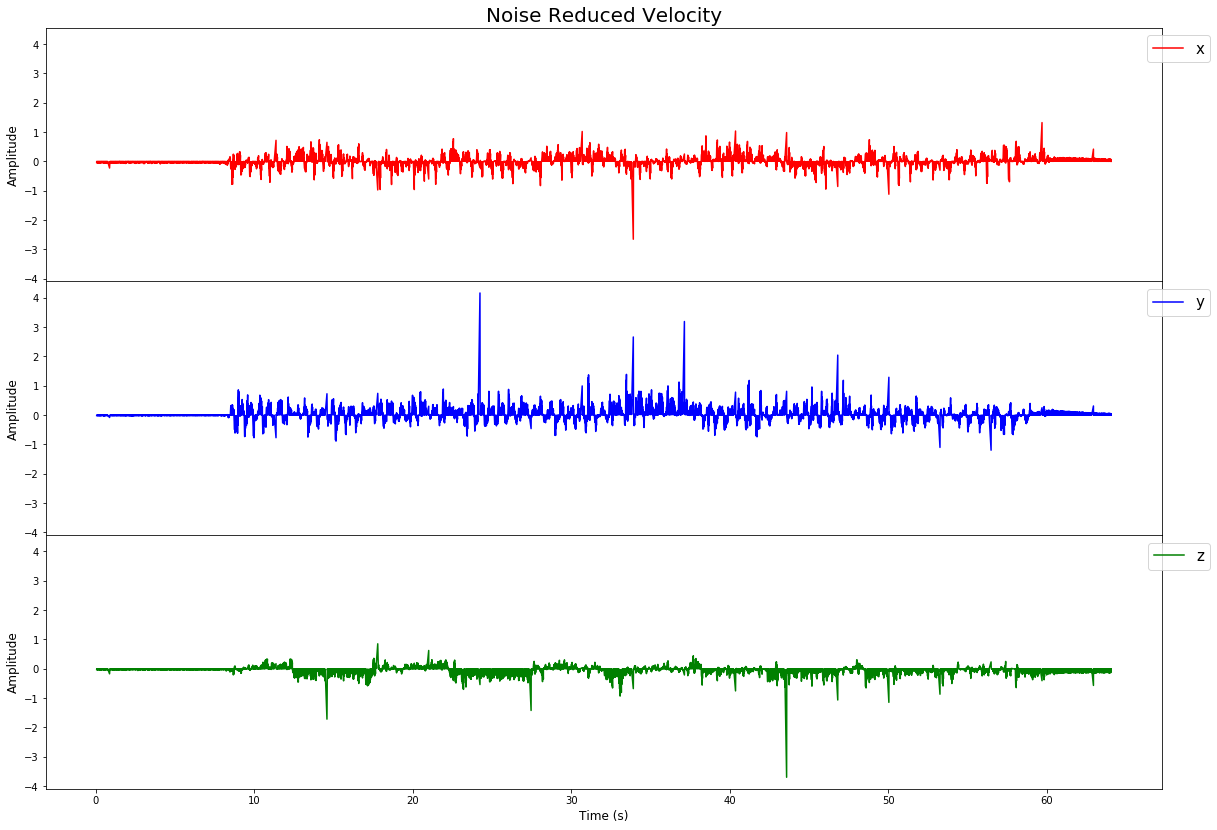

In [386]:
### GLOBAL VELOCITY PLOT (NOISE REDUCED) ###

# create 4 subfigures for acceleration: overall acceleration, as well as acceleration in the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))

ax1.plot(filtered['time'], filtered['gx_1'], 'r-', label='x')
ax2.plot(filtered['time'], filtered['gy_1'], 'b-', label='y')
ax3.plot(filtered['time'], filtered['gz_1'], 'g-', label='z')

# Format labels and title for graphs
ax1.set_title('Noise Reduced Velocity', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()


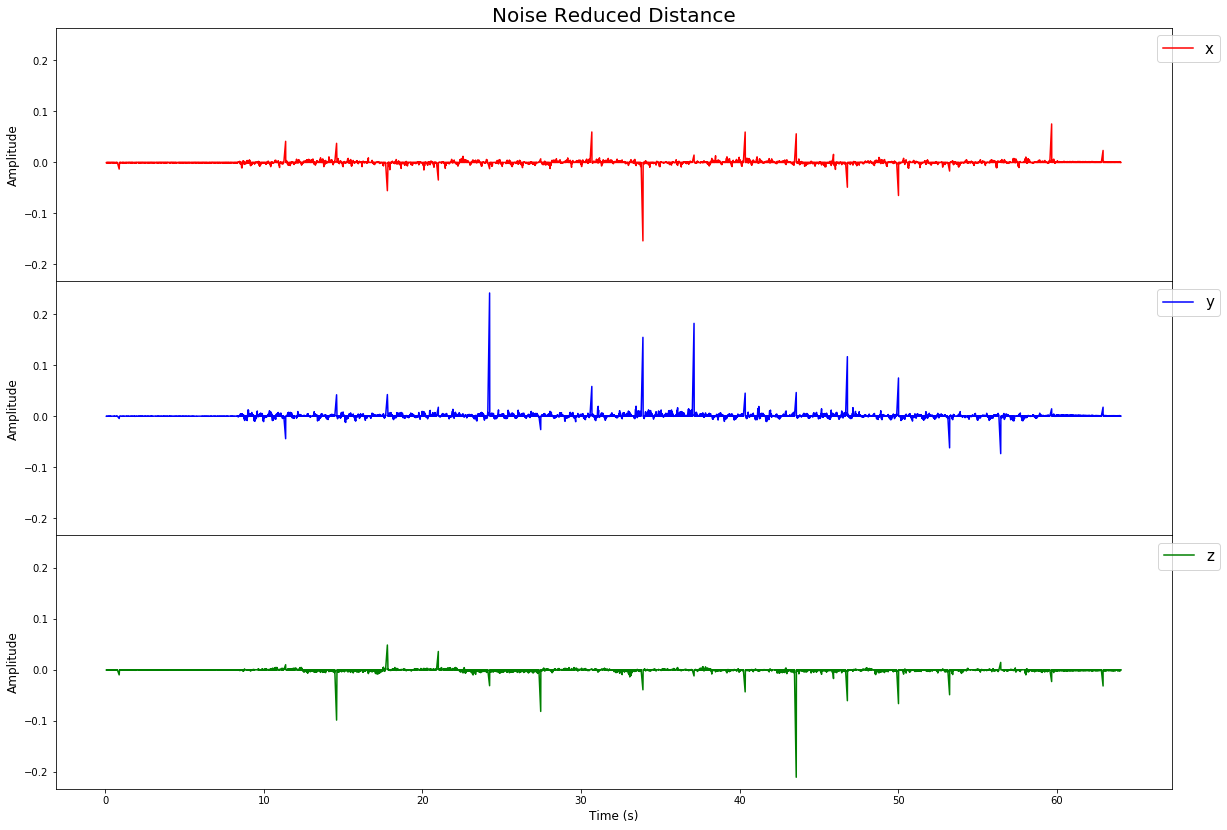

In [387]:
### GLOBAL DISTANCE PLOT (NOISE REDUCED) ###

# create 4 subfigures for acceleration: overall acceleration, as well as acceleration in the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))

ax1.plot(filtered['time'], filtered['gx_2'], 'r-', label='x')
ax2.plot(filtered['time'], filtered['gy_2'], 'b-', label='y')
ax3.plot(filtered['time'], filtered['gz_2'], 'g-', label='z')

# Format labels and title for graphs
ax1.set_title('Noise Reduced Distance', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

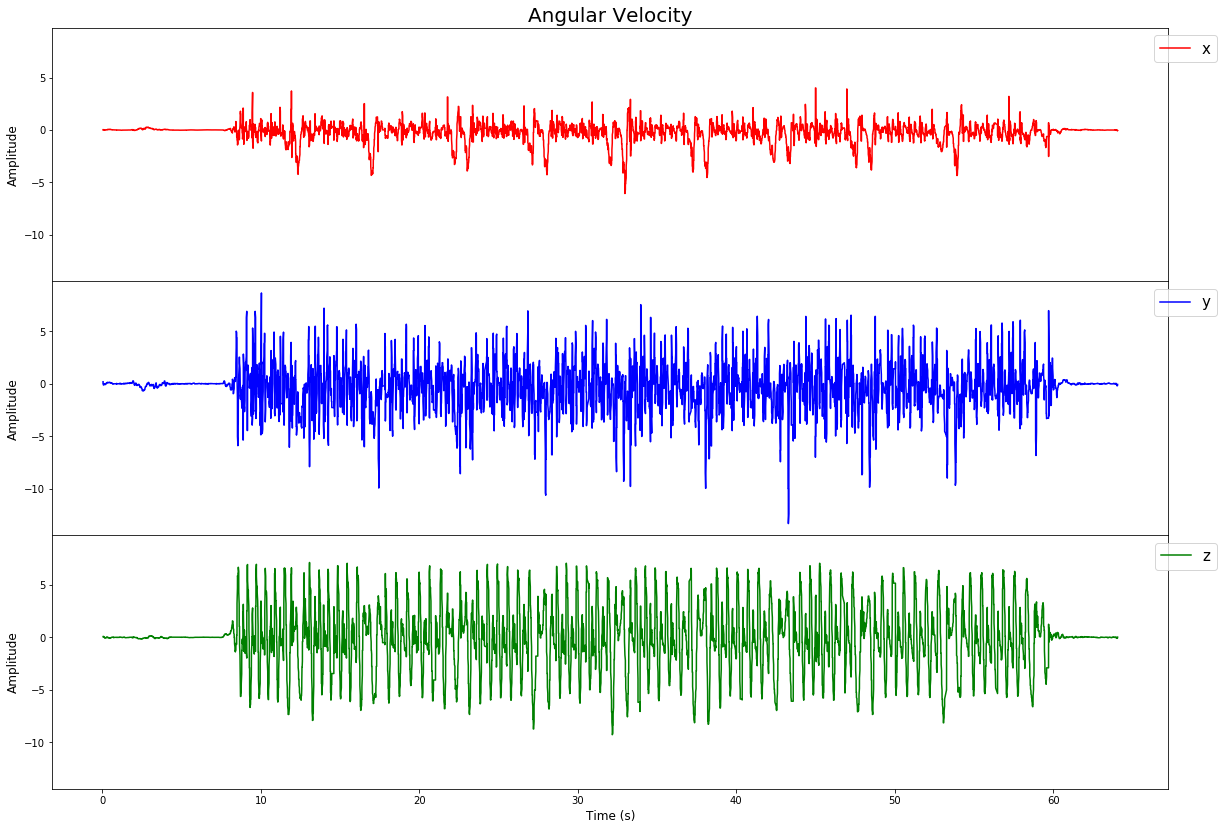

In [381]:
### ANGULAR VELOCITY PLOT ###

# create 4 subfigures for acceleration: overall acceleration, as well as acceleration in the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))

ax1.plot(global_vals['time'], global_vals['wx'], 'r-', label='x')
ax2.plot(global_vals['time'], global_vals['wy'], 'b-', label='y')
ax3.plot(global_vals['time'], global_vals['wz'], 'g-', label='z')

# Format labels and title for graphs
ax1.set_title('Angular Velocity', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

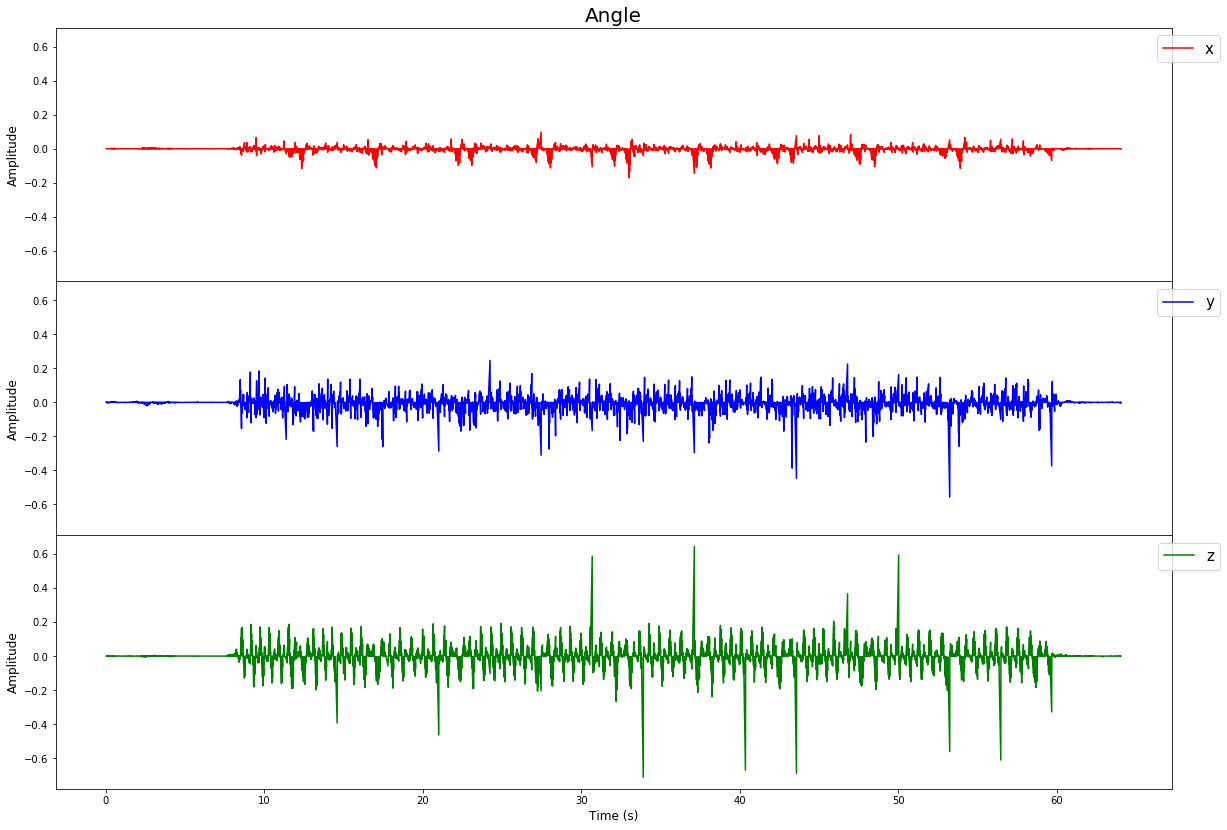

In [384]:
### ANGLE PLOT ###

# create 4 subfigures for acceleration: overall acceleration, as well as acceleration in the x-axis, y-axis, and z-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(20,14))

ax1.plot(int_1['time'], int_1['wx_1'], 'r-', label='x')
ax2.plot(int_1['time'], int_1['wy_1'], 'b-', label='y')
ax3.plot(int_1['time'], int_1['wz_1'], 'g-', label='z')

# Format labels and title for graphs
ax1.set_title('Angle', fontsize=20)
ax1.set_ylabel('Amplitude', size=12)
ax2.set_ylabel('Amplitude', size=12)
ax3.set_ylabel('Amplitude', size=12)
plt.xlabel('Time (s)', fontsize=12)

# setting up graph legends
ax1.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax2.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
ax3.legend(bbox_to_anchor=(1.05, 1), loc=1, prop={'size':15})
    
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()